## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import ee
import geemap
import os
from glob import glob
from tqdm.auto import tqdm
from datetime import datetime, timedelta

import warnings
warnings.filterwarnings('ignore')

## Define File and Directory Paths

In [2]:
# Main directory containing raw raster and vector datasets
MAIN_DATA_DIR = '/beegfs/halder/DATA'

# GitHub-linked project directory where processed data and results are stored
PROJECT_DATA_DIR = '/beegfs/halder/GITHUB/Landscape-Analysis/data'

# Temporary directory used for storing intermediate files
TEMP_DIR = os.path.join(PROJECT_DATA_DIR, 'TEMP')

## Authenticate and Initialize Earth Engine

In [3]:
# ee.Authenticate()
# ee.Initialize(project='ee-halderkrishnagopal48')

In [4]:
Map = geemap.Map(basemap='Esri.WorldImagery')
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## Import Region of Intereset and Crop Mask

In [5]:
# Import the Region of Interest
roi = ee.FeatureCollection('projects/ee-geonextgis/assets/DE/DE_NUTS_3')
roi_nuts_3 = roi.filter(ee.Filter.eq('LEVL_CODE', 3))
roi_nuts_1 = roi.filter(ee.Filter.eq('LEVL_CODE', 1))

roi_style = {
    'fillColor': '00000000',
    'width': 1,
    'color': 'red'
}
Map.addLayer(roi_nuts_1.style(**roi_style), {}, 'ROI NUTS 1')
Map.centerObject(roi, 6)

# Import the crop mask
crop_mask = ee.Image('projects/ee-geonextgis/assets/DE/DE_Wheat_Mask').clip(roi)
crop_vis = {
    'min': 1,
    'max': 5,
    'palette': ['#a50026', '#f88d52', '#ffffbf', '#86cb66', '#006837']
}
Map.addLayer(crop_mask, crop_vis, 'Crop Mask')

## Load Hexagonal Grid for Germany

In [6]:
# Define the distance
DISTANCE = 2.5

# Define the EPSG
EPSG = 25832  # Use ETRS89 / UTM Zone 32N as the projection (suitable for Germany)

# Define the crop
CROP = 'WW'
CROP_CODE = 1110

# Path to grid shapefile
GRID_PATH = os.path.join(PROJECT_DATA_DIR, 'VECTOR', f'DE_Hexbins_{DISTANCE}sqkm_EPSG_{EPSG}.shp')

# Define the out directory
OUT_DIR = os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'EVI')

# Load grid as a GeoDataFrame and retain relevant columns
grids_gdf = gpd.read_file(GRID_PATH)
grids_gdf = grids_gdf[['id', 'geometry']]
grids_gdf['id'] = grids_gdf['id'].astype(int)

print('Successfully read the grids!')
print(grids_gdf.shape)
grids_gdf.head()

Successfully read the grids!
(67545, 2)


,id,geometry
0,68921,"POLYGON ((709129.96 5565059.119, 709851.648 55..."
1,68920,"POLYGON ((709129.96 5567559.119, 709851.648 55..."
2,68923,"POLYGON ((709129.96 5560059.119, 709851.648 55..."
3,68922,"POLYGON ((709129.96 5562559.119, 709851.648 55..."
4,68925,"POLYGON ((709129.96 5555059.119, 709851.648 55..."


In [7]:
# Read the NUTS dataframe
roi_gdf = gpd.read_file(os.path.join(MAIN_DATA_DIR, 'DE_NUTS', 'DE_NUTS_3.shp'))
roi_gdf.to_crs(crs=grids_gdf.crs, inplace=True)
roi_nuts1_gdf = roi_gdf[roi_gdf['LEVL_CODE']==1]
roi_nuts3_gdf = roi_gdf[roi_gdf['LEVL_CODE']==3]
roi_nuts1_gdf = roi_nuts1_gdf[['NUTS_ID', 'NUTS_NAME', 'geometry']].rename(columns={'NUTS_ID': 'STATE_ID', 'NUTS_NAME': 'STATE_NAME'})
roi_nuts3_gdf = roi_nuts3_gdf[['NUTS_ID', 'NUTS_NAME', 'geometry']]
print(roi_nuts3_gdf.shape)
roi_nuts3_gdf.head()

(400, 3)


,NUTS_ID,NUTS_NAME,geometry
0,DE11B,Main-Tauber-Kreis,"POLYGON ((546793.49 5514433.543, 546531.283 55..."
1,DE11C,Heidenheim,"MULTIPOLYGON (((585299.35 5401977.751, 585395...."
2,DE11D,Ostalbkreis,"MULTIPOLYGON (((591812.28 5434830.278, 591515...."
3,DE121,"Baden-Baden, Stadtkreis","MULTIPOLYGON (((440009.175 5410196.803, 441490..."
4,DE122,"Karlsruhe, Stadtkreis","POLYGON ((458238.847 5435551.545, 459823.952 5..."


In [8]:
# Combine the crop class metrics
crop_class_metrics_paths = glob(os.path.join(PROJECT_DATA_DIR, 'OUTPUT', f'Landscape_Metrics_{DISTANCE}KM', 'crop_class_metrics_*.csv'))
crop_class_metrics_dfs = [pd.read_csv(fp) for fp in crop_class_metrics_paths]
crop_class_metrics_df = pd.concat(crop_class_metrics_dfs, axis=0, ignore_index=True)
crop_class_metrics_df = crop_class_metrics_df[crop_class_metrics_df['class_val']==CROP_CODE]

crop_area_proportion = crop_class_metrics_df[['id', 'proportion_of_landscape']].groupby(by=['id']).mean().reset_index()
crop_area_proportion.rename(columns={'proportion_of_landscape': 'proportion_of_crop'}, inplace=True)

# Drop hexbins with crop area less than 5%
crop_area_proportion = crop_area_proportion[crop_area_proportion['proportion_of_crop']>=5]

# Merge the 'proportion_of_crop' with the grids_gdf
grids_gdf = pd.merge(left=grids_gdf, right=crop_area_proportion, on='id', how='inner')
print(crop_area_proportion.shape)
crop_area_proportion.head()

(52956, 2)


,id,proportion_of_crop
0,177,16.542732
1,178,24.296560
2,179,18.757839
3,180,33.856094
4,523,6.663828


In [9]:
grids_centroids = grids_gdf.copy()
grids_centroids['geometry'] = grids_gdf.centroid

grids_centroids = gpd.sjoin_nearest(left_df=grids_centroids, right_df=roi_nuts1_gdf[['STATE_ID', 'STATE_NAME', 'geometry']],
                                    how='inner').drop(columns=['index_right'])
grids_centroids = gpd.sjoin_nearest(left_df=grids_centroids, right_df=roi_nuts3_gdf[['NUTS_ID', 'NUTS_NAME', 'geometry']],
                                    how='inner').drop(columns=['index_right'])

grids_gdf = pd.merge(left=grids_gdf, right=grids_centroids[['id', 'STATE_ID', 'STATE_NAME', 'NUTS_ID', 'NUTS_NAME']], 
                     how='inner', on='id')
print(grids_gdf.shape)
grids_gdf.head()

(52956, 7)


,id,geometry,proportion_of_crop,STATE_ID,STATE_NAME,NUTS_ID,NUTS_NAME
0,68921,"POLYGON ((709129.96 5565059.119, 709851.648 55...",10.645853,DE2,Bayern,DE24D,Wunsiedel i. Fichtelgebirge
1,68920,"POLYGON ((709129.96 5567559.119, 709851.648 55...",9.438970,DE2,Bayern,DE249,"Hof, Landkreis"
2,68923,"POLYGON ((709129.96 5560059.119, 709851.648 55...",6.323348,DE2,Bayern,DE24D,Wunsiedel i. Fichtelgebirge
3,68922,"POLYGON ((709129.96 5562559.119, 709851.648 55...",17.598030,DE2,Bayern,DE24D,Wunsiedel i. Fichtelgebirge
4,68913,"POLYGON ((709129.96 5585059.119, 709851.648 55...",11.543908,DE2,Bayern,DE249,"Hof, Landkreis"


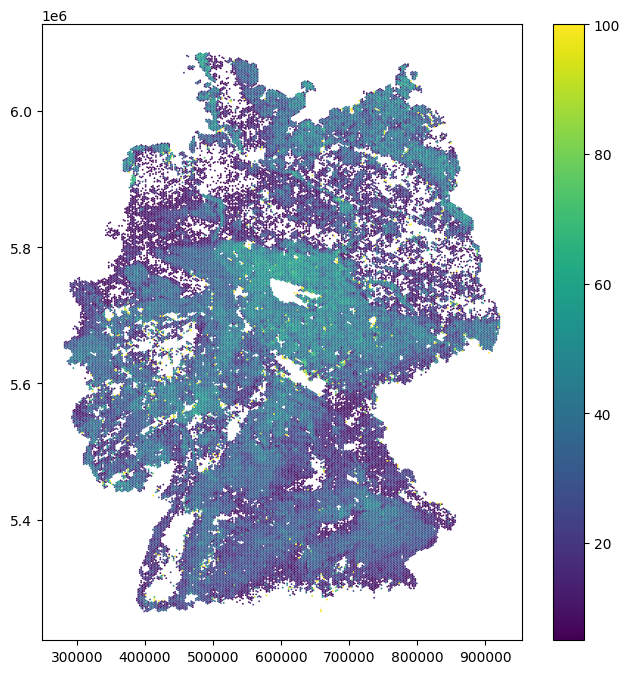

In [10]:
grids_gdf.plot(column='proportion_of_crop', figsize=(8, 8), legend=True);

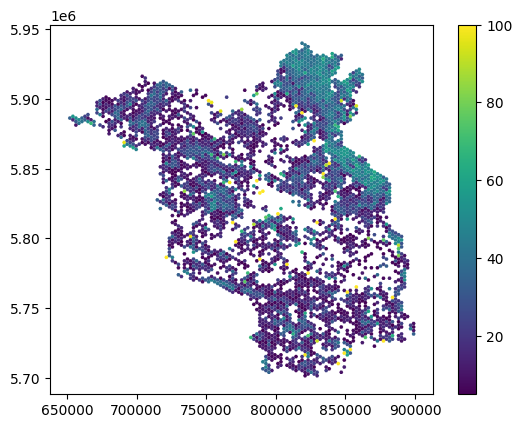

In [11]:
grids_gdf[grids_gdf['STATE_NAME'].isin(['Berlin', 'Brandenburg'])].plot(column='proportion_of_crop', legend=True);

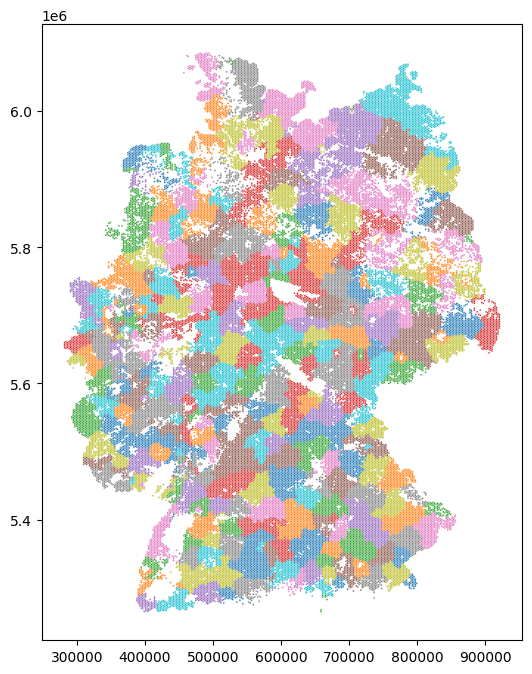

In [12]:
grids_gdf.plot(column='NUTS_NAME', edgecolor='w', linewidth=0.15, figsize=(8, 8));

## Read the Crop Yield Data

In [13]:
# Read the crop yield data
yield_df = pd.read_csv(os.path.join(MAIN_DATA_DIR, 'DE_Crop_Yield', 'DE_Crop_Yield_Master.csv'))
yield_df = yield_df[yield_df['var']=='ww']
yield_df = yield_df[['nuts_id', 'year', 'value']]
yield_df.rename(columns={'nuts_id': 'NUTS_ID', 'year': 'Year', 'value': 'Yield'}, inplace=True)
print(yield_df.shape)
yield_df.head()

(17850, 3)


,NUTS_ID,Year,Yield
9,DEF01,1979,5.29
19,DEF01,1980,5.02
29,DEF01,1981,5.74
39,DEF01,1982,6.90
49,DEF01,1983,6.32


## Analyze Phenology for Each State

In [14]:
# Read the phenology data
phenology_df = pd.read_csv(os.path.join(MAIN_DATA_DIR, 'DE_Crop_Phenology', 'WW_phenology_1999_2021.csv'))
phenology_df.rename(columns={'Sowing_DOY': 'Sowing_DATE', 'Flowering_DOY': 'Flowering_DATE', 'Harvest_DOY': 'Harvest_DATE'}, inplace=True)
for date_col in ['Sowing_DATE', 'Flowering_DATE', 'Harvest_DATE']:
    event = date_col.split("_")[0]
    phenology_df[date_col] = pd.to_datetime(phenology_df[date_col], format='%Y-%m-%d')
    phenology_df[f'{event}_DOY'] = phenology_df[date_col].dt.dayofyear

# Group by STATE_ID and take the median of DOYs
median_doys = phenology_df.groupby('STATE_NAME')[['Sowing_DOY', 'Harvest_DOY']].median().round().astype(int).reset_index()
phenology_df = phenology_df.merge(median_doys, on='STATE_NAME', suffixes=('', '_MEDIAN'))

print(phenology_df.shape)
phenology_df.head()

(356, 13)


,STATE_ID,STATE_NAME,Year,Sowing_DATE,Flowering_DATE,Harvest_DATE,Duration_Sowing_to_Flowering,Duration_Flowering_to_Harvest,Sowing_DOY,Flowering_DOY,Harvest_DOY,Sowing_DOY_MEDIAN,Harvest_DOY_MEDIAN
0,DE1,Baden-Württemberg,1999,1998-10-12,1999-05-30,1999-08-03,230,65,285,150,215,283,212
1,DE2,Bayern,1999,1998-10-10,1999-06-02,1999-08-07,235,66,283,153,219,281,215
2,DE3,Berlin,1999,1998-10-06,1999-05-29,1999-08-04,235,67,279,149,216,276,213
3,DE4,Brandenburg,1999,1998-10-06,1999-05-29,1999-08-04,235,67,279,149,216,276,213
4,DE5,Bremen,1999,1998-10-09,1999-05-31,1999-08-09,234,70,282,151,221,280,218


In [15]:
# Create full year range
years = list(range(2001, 2024 + 1))

# Create cartesian product of states and years
phenology_median = pd.MultiIndex.from_product([median_doys['STATE_NAME'], years], names=['STATE_NAME', 'Year']).to_frame(index=False)

# Merge back state names and median DOYs
phenology_median = phenology_median.merge(median_doys, on='STATE_NAME', how='left')

def doy_to_date(year, doy, event='sow'):
    if event == 'sow':
        return datetime(year-1, 1, 1) + timedelta(days=int(doy) - 1)
    else:
        return datetime(year, 1, 1) + timedelta(days=int(doy) - 1)

phenology_median['Sowing_DATE'] = phenology_median.apply(lambda row: doy_to_date(row['Year'], row['Sowing_DOY'], event='sow'), axis=1)
phenology_median['Harvest_DATE'] = phenology_median.apply(lambda row: doy_to_date(row['Year'], row['Harvest_DOY'], event='harvest'), axis=1)

print(phenology_median.shape)
phenology_median.head()

(384, 6)


,STATE_NAME,Year,Sowing_DOY,Harvest_DOY,Sowing_DATE,Harvest_DATE
0,Baden-Württemberg,2001,283,212,2000-10-09,2001-07-31
1,Baden-Württemberg,2002,283,212,2001-10-10,2002-07-31
2,Baden-Württemberg,2003,283,212,2002-10-10,2003-07-31
3,Baden-Württemberg,2004,283,212,2003-10-10,2004-07-30
4,Baden-Württemberg,2005,283,212,2004-10-09,2005-07-31


In [16]:
def get_phenology(state_name, year):
    index = phenology_median[(phenology_median['STATE_NAME']==state_name) & (phenology_median['Year']==year)].index[0]
    data_dict = phenology_median.loc[index].to_dict()
    data_dict['Sowing_DATE'] = data_dict['Sowing_DATE'].strftime('%Y-%m-%d')
    data_dict['Harvest_DATE'] = data_dict['Harvest_DATE'].strftime('%Y-%m-%d')
    return data_dict

## Process EVI Data

In [17]:
def compute_hexbin_mean_evi(state: str, year: int, out_dir: str = "output"):
    # Step 1: Filter hexbin grids for the selected state
    grids_gdf_filtered = grids_gdf[grids_gdf['STATE_NAME'] == state]

    # Step 2: Filter yield data
    nut_ids = grids_gdf_filtered['NUTS_ID'].unique()
    yield_df_filtered = yield_df[
        (yield_df['Year'] == year) & 
        (yield_df['NUTS_ID'].isin(nut_ids))
    ].dropna()
    yield_nut_ids = yield_df_filtered['NUTS_ID'].unique()

    # Step 3: Keep only hex grids that match NUTS IDs with yield data
    grids_gdf_filtered = grids_gdf_filtered[
        grids_gdf_filtered['NUTS_ID'].isin(yield_nut_ids)
    ]

    if grids_gdf_filtered.empty:
        print(f"No grid data found for {state} in {year}")
        return pd.DataFrame()

    # Step 4: Convert state boundary to EE
    state_gdf_ee = roi.filter(ee.Filter.eq('NUTS_NAME', state)).first()

    # Step 5: Get phenology info
    phenology = get_phenology(state, year)

    # Step 6: Load and preprocess MODIS EVI
    modis_evi = ee.ImageCollection("MODIS/061/MOD13Q1").select('EVI')
    modis_evi_temporal_mean = (
        modis_evi
        .filterDate(phenology['Sowing_DATE'], phenology['Harvest_DATE'])
        .map(lambda img: img.multiply(0.0001))
        .mean()
        .clip(state_gdf_ee)
        .updateMask(crop_mask)
        .rename('EVI_Mean')
    )

    # Step 7: Define reducer function
    def add_mean_evi(feature):
        mean_evi = modis_evi_temporal_mean.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=feature.geometry(),
            scale=250,
            maxPixels=1e9
        ).get('EVI_Mean')
        return feature.set('mean_evi', mean_evi)

    # Step 8: Batch processing
    batch_size = 1000
    if len(grids_gdf_filtered) > batch_size:
        results_df = pd.DataFrame()
        num_batches = (len(grids_gdf_filtered) + batch_size - 1) // batch_size
    
        print(f"Processing {len(grids_gdf_filtered)} grids in {num_batches} batches...")
    
        for i in range(num_batches):
            batch = grids_gdf_filtered.iloc[i * batch_size : (i + 1) * batch_size]
            batch_ee = geemap.gdf_to_ee(batch[['id', 'NUTS_ID', 'geometry']])
            batch_with_evi = batch_ee.map(add_mean_evi)
            batch_df = geemap.ee_to_df(batch_with_evi)
            results_df = pd.concat([results_df, batch_df], ignore_index=True)

    else:
        grids_gdf_filtered_ee = geemap.gdf_to_ee(grids_gdf_filtered)
        results_df = grids_gdf_filtered_ee.map(add_mean_evi)
        results_df = geemap.ee_to_df(results_df)
        
    results_df['year'] = year
    results_df = results_df[['id', 'NUTS_ID', 'year', 'mean_evi']]
    
    # Step 9: Save to CSV
    os.makedirs(out_dir, exist_ok=True)
    filename = f"{state.replace(' ', '_')}_{year}_evi.csv"
    filepath = os.path.join(out_dir, filename)
    results_df.to_csv(filepath, index=False)
    print(f"Saved results to {filepath}")

In [22]:
# Start the data extraction
states = sorted(grids_gdf['STATE_NAME'].unique())
for state in tqdm(states[3:], total=len(states)):
    for year in phenology_median['Year'].unique():
        compute_hexbin_mean_evi(state, year, OUT_DIR)

  0%|          | 0/16 [00:00<?, ?it/s]

Processing 3659 grids in 4 batches...
Saved results to /beegfs/halder/GITHUB/Landscape-Analysis/data/OUTPUT/Landscape_Metrics_2.5KM/EVI/Brandenburg_2001_evi.csv
Processing 3659 grids in 4 batches...
Saved results to /beegfs/halder/GITHUB/Landscape-Analysis/data/OUTPUT/Landscape_Metrics_2.5KM/EVI/Brandenburg_2002_evi.csv
Processing 3628 grids in 4 batches...
Saved results to /beegfs/halder/GITHUB/Landscape-Analysis/data/OUTPUT/Landscape_Metrics_2.5KM/EVI/Brandenburg_2003_evi.csv
Processing 3659 grids in 4 batches...
Saved results to /beegfs/halder/GITHUB/Landscape-Analysis/data/OUTPUT/Landscape_Metrics_2.5KM/EVI/Brandenburg_2004_evi.csv
Processing 3628 grids in 4 batches...
Saved results to /beegfs/halder/GITHUB/Landscape-Analysis/data/OUTPUT/Landscape_Metrics_2.5KM/EVI/Brandenburg_2005_evi.csv
Processing 3628 grids in 4 batches...
Saved results to /beegfs/halder/GITHUB/Landscape-Analysis/data/OUTPUT/Landscape_Metrics_2.5KM/EVI/Brandenburg_2006_evi.csv
Processing 3628 grids in 4 batches